---
# 5. Clasificador

<div style="text-align: justify;">

En esta sección hemos desarrollado un clasificador de textos basado en redes neuronales. Partiendo de un dataset que ya habíamos limpiado y preprocesado en etapas anteriores, nos hemos centrado en la preparación del texto para abordar un problema de clasificación binaria, diferenciando entre libros de ficción y no ficción a partir de sus descripciones.

Desde el inicio, transformamos las descripciones en secuencias de tokens mediante técnicas de tokenización y padding, lo que nos permitió homogeneizar la longitud de las entradas y limitar el vocabulario a las palabras más relevantes. Esta transformación es clave para poder alimentar de manera adecuada la red neuronal y garantizar que el modelo pueda aprender patrones significativos en el texto.

La arquitectura elegida para el clasificador se basa en una red LSTM bidireccional. Hemos optado por esta arquitectura porque, tras haberla visto en clase, teníamos especial curiosidad por experimentar con ella. La capacidad de la LSTM para capturar dependencias a largo plazo en los datos secuenciales la hace particularmente atractiva para el análisis de descripciones literarias, ya que permite extraer patrones contextuales que pueden ser determinantes para diferenciar entre ficción y no ficción.

Además, hemos incorporado técnicas de regularización como el Dropout y ajustado ciertos aspectos del entrenamiento, como la utilización de EarlyStopping y la aplicación de pesos de clase, para mitigar el riesgo de overfitting y manejar el desbalance de las clases en el dataset. Aunque no entramos ahora en detalles específicos de los parámetros, este enfoque nos ha permitido evaluar de forma efectiva la capacidad de generalización del modelo, comprobando su desempeño tanto en los conjuntos de entrenamiento como en los de validación y prueba.

</div>

---
## 5.1. Carga de los datos

Cargamos el dataset que fue previamente limpiado durante el análisis exploratorio de datos (EDA). Este conjunto ya incluye descripciones de libros procesadas en inglés, lo que nos permite centrarnos directamente en la preparación para el modelado.


In [4]:
import pandas as pd

In [5]:
dataset = pd.read_csv('datasets/clean_description_english.csv')

In [6]:
import pandas as pd

import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential

from keras.layers import Embedding, SimpleRNN, Dense

import matplotlib.pyplot as plt


---
## 5.2. Mapeo de categorías: creación de la variable objetivo

Creamos una función personalizada para transformar la columna 'genre' del dataset en una variable binaria que nos permita clasificar los libros como ficción (1) o no ficción (0). Esta transformación es crucial para poder abordar el problema como una clasificación binaria.


In [7]:
def map_category(cat):
    cat = str(cat).lower()
    # Separamos los valores en tokens usando la coma como separador
    tokens = [token.strip() for token in cat.split(',')]
    # Si se encuentra la palabra "nonfiction" en alguno de los tokens, clasificamos como no ficción (0)
    if any("nonfiction" in token for token in tokens):
        return 0
    if any("non fiction" in token for token in tokens):
        return 0
    # Si no se encontró "nonfiction" y aparece "fiction", clasificamos como ficción (1)
    if any("fiction" in token for token in tokens):
        return 1
    # En caso contrario, por defecto se clasifica como no ficción (0)
    return 0
 
# Aplicamos la función de mapeo a la columna 'column4'

dataset['label'] = dataset['genre'].apply(map_category)


---
## 5.3. Preprocesamiento del texto

Procedemos a la tokenización y el padding de las descripciones para preparar los datos de entrada para la red neuronal. Limitamos el vocabulario a las 10.000 palabras más frecuentes y unificamos la longitud de las secuencias a 500 tokens para mantener consistencia en la entrada del modelo.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam  # Importar Adam con opción de LR personalizada
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
 

 
texts = dataset['clean_description'].fillna("").tolist()
labels = dataset['label'].values
 
# Tokenización y Padding
max_features = 10000  # Número máximo de palabras a considerar
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 500  # Longitud máxima de cada secuencia
data = pad_sequences(sequences, maxlen=maxlen)
print("Forma de las secuencias procesadas:", data.shape)

Forma de las secuencias procesadas: (17452, 500)


---
## 5.4. Modelo de clasificación



Dividimos el dataset en un 80% para entrenamiento y un 20% para prueba, asegurando que la distribución de clases se mantenga mediante estratificación. Además, calculamos los pesos de las clases para mitigar el desbalance y ayudar al modelo a aprender de manera más equitativa.

In [9]:

# --------------------------------------------------------------------------------
# División del dataset (Entrenamiento y Prueba) con estratificación
# --------------------------------------------------------------------------------
 
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)
print("Tamaño del train:", X_train.shape, "Tamaño del test:", X_test.shape)
 
# --------------------------------------------------------------------------------
# Cálculo de los pesos de clases para compensar el desbalance
# --------------------------------------------------------------------------------
 
clases = np.unique(y_train)
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_train)
class_weights = {i: peso for i, peso in zip(clases, pesos)}
print("Pesos de clases:", class_weights)

Tamaño del train: (13961, 500) Tamaño del test: (3491, 500)
Pesos de clases: {0: 1.8206833594157539, 1: 0.6892959415424114}


### Definición de la arquitectura del modelo

Definimos una red neuronal secuencial con las siguientes capas:
- Capa de Embedding para representar las palabras en vectores densos.
- Dropout del 30% para reducir el sobreajuste.
- Capa LSTM bidireccional para capturar dependencias contextuales en ambas direcciones del texto, también con dropout.
- Capa densa final con activación sigmoide para realizar la clasificación binaria.

Optamos por una tasa de aprendizaje baja (`1e-4`) utilizando el optimizador Adam, buscando una convergencia más estable durante el entrenamiento.

### Configuración de Early Stopping

Configuramos una estrategia de parada temprana para detener el entrenamiento si la pérdida de validación no mejora después de 4 épocas consecutivas. Esto nos ayuda a prevenir el sobreajuste y optimizar el uso de recursos computacionales.

### Entrenamiento del modelo

Entrenamos el modelo con:
- Un máximo de 20 épocas.
- Batch size reducido a 64 para actualizaciones de gradiente más frecuentes.
- Validación interna del 20% del conjunto de entrenamiento.
- Aplicación de pesos de clase calculados previamente.

Este enfoque nos permite encontrar un buen equilibrio entre rendimiento y generalización del modelo.

### Evaluación del modelo

Evaluamos el modelo en el conjunto de prueba separado para obtener métricas finales de rendimiento. Esto nos permite tener una visión honesta del comportamiento del modelo sobre datos no vistos.

### Visualización de métricas de entrenamiento

Graficamos la evolución de la precisión y la pérdida durante las épocas de entrenamiento y validación. Esta visualización nos ayuda a comprender el comportamiento del modelo y a identificar posibles síntomas de sobreajuste o bajoajuste.


c:\Users\ruben\anaconda3\envs\MLMBD\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 111s 588ms/step - acc: 0.4794 - loss: 0.6914 - val_acc: 0.7103 - val_loss: 0.6891
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 99s 563ms/step - acc: 0.6763 - loss: 0.6891 - val_acc: 0.6248 - val_loss: 0.6835
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 100s 571ms/step - acc: 0.6672 - loss: 0.6554 - val_acc: 0.7898 - val_loss: 0.5665
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 95s 545ms/step - acc: 0.7720 - loss: 0.5636 - val_acc: 0.7683 - val_loss: 0.6272
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 93s 532ms/step - acc: 0.8205 - loss: 0.5131 - val_acc: 0.8281 - val_loss: 0.5466
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 91s 522ms/step - acc: 0.8573 - loss: 0.4661 - val_acc: 0.8453 - val_loss: 0.5123
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 89s 508ms/step - acc: 0.8611 - loss: 0.4557 - val_acc: 0.8453 - val_loss: 0.4906
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 92s 528ms/step - acc: 0.8733 - loss: 0.4328 - val_acc: 0.8622 - val_loss: 0.4739
Epoch 9/20
175/175 ━━━━━━━━━━━

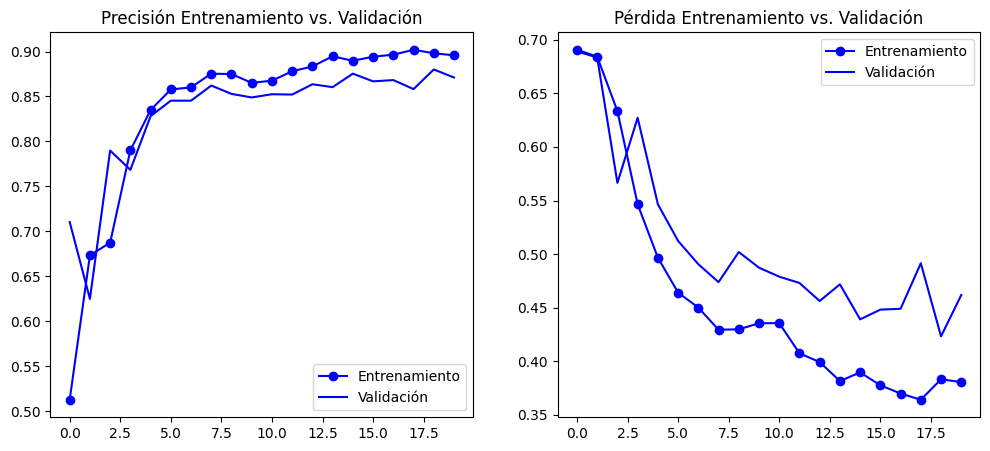

In [10]:
# --------------------------------------------------------------------------------
# Definición del modelo con mayor regularización y tasa de aprendizaje reducida
# --------------------------------------------------------------------------------
 
model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen))
model.add(Dropout(0.3))  # Dropout incrementado (de 0.1 a 0.3)
model.add(Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)))  # Dropout incrementado en la LSTM
model.add(Dense(1, activation='sigmoid'))
model.summary()
 
# Compilar el modelo utilizando Adam con una tasa de aprendizaje más baja
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # LR reducido para un aprendizaje más estable
    loss='binary_crossentropy',
    metrics=['acc']
)

# --------------------------------------------------------------------------------
# EarlyStopping para detener el entrenamiento si no hay mejora en la validación
# --------------------------------------------------------------------------------
 
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
 
# --------------------------------------------------------------------------------
# Entrenamiento del modelo
# --------------------------------------------------------------------------------
 
history = model.fit(
    X_train,
    y_train,
    epochs=20,            # Se permite más cantidad de épocas
    batch_size=64,        # Batch size reducido para actualizaciones más frecuentes
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights
)
 
# --------------------------------------------------------------------------------
# Evaluación en el conjunto de prueba
# --------------------------------------------------------------------------------
 
score = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPérdida en Test: {score[0]:.4f}")
print(f"Precisión en Test: {score[1]:.4f}")
 
# --------------------------------------------------------------------------------
# Visualización de la Precisión y Pérdida durante el Entrenamiento y Validación
# --------------------------------------------------------------------------------
 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
 
plt.figure(figsize=(12, 5))
 
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Entrenamiento')
plt.plot(epochs_range, val_acc, 'b-', label='Validación')
plt.title('Precisión Entrenamiento vs. Validación')
plt.legend()
 
plt.subplot(1, 2, 2)  
plt.plot(epochs_range, loss, 'bo-', label='Entrenamiento')
plt.plot(epochs_range, val_loss, 'b-', label='Validación')
plt.title('Pérdida Entrenamiento vs. Validación')
plt.legend()
 
plt.show()
 
 

In [11]:
model.save("modelos/LSTM_clasificador.h5")

In [12]:
# Guardar el tokenizer
import pickle
with open('modelos/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# # Cargar el modelo guardado
# modelo_cargado = load_model("modelo_rnn_ficcion_no_ficcion.h5")

### Función de predicción con nueva descripción

Definimos una función que permite realizar predicciones sobre nuevas descripciones de libros, utilizando el modelo y el tokenizer guardados. Esto nos facilita la integración del modelo en aplicaciones del mundo real.


In [14]:
# Función para predecir usando la descripción del libro
def predecir_descripcion(descripcion):
    # Convertir la descripción a secuencia de tokens
    secuencia = tokenizer.texts_to_sequences([descripcion])
    # Aplicar padding
    secuencia_padded = pad_sequences(secuencia, maxlen=500)
    # Hacer la predicción
    prediccion = model.predict(secuencia_padded)[0][0]
    # Interpretar la salida
    if prediccion >= 0.5:
        return f"Ficción ({prediccion:.2f})"
    else:
        return f"No ficción ({prediccion:.2f})"


### Ejemplo de predicción

Probamos la función de predicción utilizando una descripción de ejemplo para verificar que el flujo completo desde la entrada del usuario hasta la predicción final funciona correctamente.


In [15]:

# Ejemplo de uso
descripcion_libro = """
In the summer of 1878, Sherlock Holmes and Dr. Watson solve a mysterious case of a secret society.
"""
resultado = predecir_descripcion(descripcion_libro)
print("Resultado:", resultado)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
Resultado: Ficción (0.85)


---
## 5.5. Pruebas


### 5.5.1 Bidirectional LSTM con `train_test_split`

#### Descripción:
Este modelo utiliza una arquitectura sencilla pero efectiva de Bidirectional LSTM.  
- **Preprocesamiento:**  
  - Tokenización de los textos con un vocabulario máximo de 10,000 palabras.
  - Secuencias normalizadas a una longitud máxima de 500 tokens.
  - Uso de `train_test_split` con estratificación para mantener la proporción de clases en train y test.
- **Modelo:**  
  - Capa de Embedding de 32 dimensiones.
  - Capa Bidirectional LSTM con 32 unidades, regularizada con `dropout=0.1` y `recurrent_dropout=0.1`.
  - Capa densa de salida con activación sigmoide.
- **Entrenamiento:**  
  - Uso de pesos de clase (`class_weight`) para manejar el desbalanceo.
  - EarlyStopping con paciencia de 3 para prevenir overfitting.
  - Entrenamiento durante hasta 10 épocas, batch size de 128.

#### Por qué no se selecciona:
- **Overfitting detectado:**  
  Claros indicios de overfitting tras pocas épocas, con una diferencia evidente entre la precisión de entrenamiento y validación.
- **Rendimiento moderado:**  
  Aunque la precisión en train es alta, la precisión en test no mejora sustancialmente frente a enfoques más simples.
- **Clase minoritaria mal resuelta:**  
  A pesar de aplicar `class_weight`, las predicciones sobre la clase menos representada siguen siendo flojas.
- **Coste computacional elevado:**  
  El modelo requiere un tiempo de entrenamiento considerable en comparación con su desempeño final.

Forma de las secuencias procesadas: (17452, 500)
Tamaño del train: (8726, 500) Tamaño del test: (8726, 500)
Pesos de clases: {0: 1.8217118997912318, 1: 0.6891486337071553}


c:\Users\ruben\anaconda3\envs\MLMBD\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - acc: 0.6078 - loss: 0.6844 - val_acc: 0.7537 - val_loss: 0.5749
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - acc: 0.8224 - loss: 0.4992 - val_acc: 0.8688 - val_loss: 0.4250
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - acc: 0.8866 - loss: 0.3879 - val_acc: 0.8786 - val_loss: 0.3810
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - acc: 0.9181 - loss: 0.3155 - val_acc: 0.8832 - val_loss: 0.3492
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - acc: 0.9283 - loss: 0.2926 - val_acc: 0.8803 - val_loss: 0.3602
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - acc: 0.9401 - loss: 0.2459 - val_acc: 0.8895 - val_loss: 0.3302
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - acc: 0.9431 - loss: 0.2056 - val_acc: 0.8414 - val_loss: 0.3848
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - acc: 0.9567 - loss: 0.1644 - val_acc: 0.8494 - val_loss: 0.3968
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - acc: 0.9682 - loss:

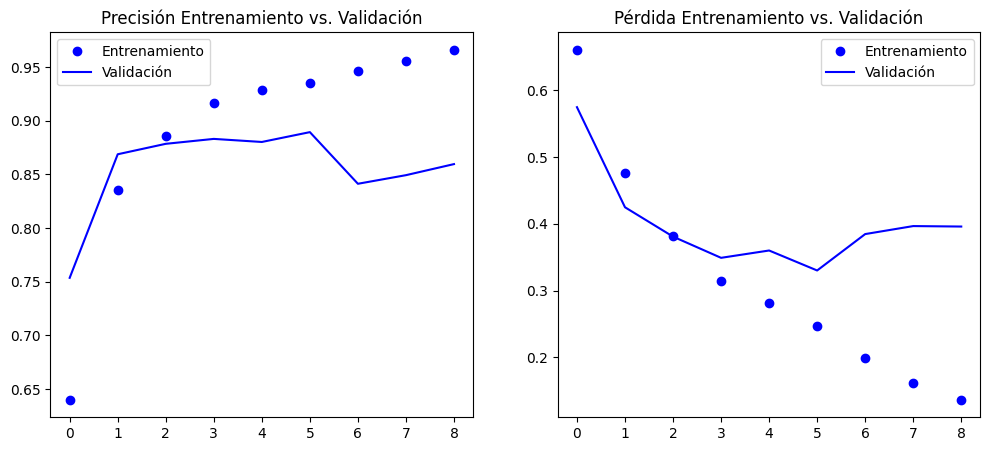

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight



# Preprocesamiento de texto
texts = dataset['clean_description'].fillna("").tolist()
labels = dataset['label'].values

# Tokenización y Padding
max_features = 10000  # Número máximo de palabras a considerar
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 500  # Longitud máxima de cada secuencia
data = pad_sequences(sequences, maxlen=maxlen)
print("Forma de las secuencias procesadas:", data.shape)

# Dividir entre entrenamiento y prueba, usando estratificación para mantener la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.5, random_state=42, stratify=labels
)

print("Tamaño del train:", X_train.shape, "Tamaño del test:", X_test.shape)

# Calcular pesos de clases en el conjunto de entrenamiento para contrarrestar el desbalanceo
clases = np.unique(y_train)
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_train)
class_weights = {i: peso for i, peso in zip(clases, pesos)}
print("Pesos de clases:", class_weights)

# Definición del modelo
model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.1)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Callback de EarlyStopping para detener el entrenamiento si no mejora
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo utilizando el conjunto de entrenamiento y evaluándolo con el de prueba
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights
)

# Evaluar el modelo en el conjunto de prueba
score = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPérdida en Test: {score[0]:.4f}")
print(f"Precisión en Test: {score[1]:.4f}")

# Visualización de la precisión y pérdida durante el entrenamiento y validación
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo', label='Entrenamiento')
plt.plot(epochs_range, val_acc, 'b', label='Validación')
plt.title('Precisión Entrenamiento vs. Validación')
plt.legend()
 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo', label='Entrenamiento')
plt.plot(epochs_range, val_loss, 'b', label='Validación')
plt.title('Pérdida Entrenamiento vs. Validación')
plt.legend()

plt.show()



### 5.5.2. Bidirectional LSTM sin `train_test_split` (solo `validation_split`)

#### Descripción:
Este segundo modelo sigue una estructura similar al anterior, pero con una diferencia importante en la partición de datos:
- **Preprocesamiento:**  
  - Misma tokenización y padding que el modelo 1.
  - **No se realiza `train_test_split`**, se usa el dataset completo y se separa únicamente usando `validation_split=0.2` durante el entrenamiento.
- **Modelo:**  
  - Capa de Embedding de 32 dimensiones.
  - Capa Bidirectional LSTM con 32 unidades, con `dropout=0.1` y `recurrent_dropout=0.1`.
  - Capa de salida con activación sigmoide.
- **Entrenamiento:**  
  - Aplicación de pesos de clase para combatir el desbalanceo.
  - EarlyStopping con paciencia de 3.
  - Batch size de 128, hasta 10 épocas.

#### Por qué no se selecciona:
- **Problemas con la validación interna:**  
  Al no separar explícitamente un conjunto de test, no podemos estar seguros de que los resultados del modelo sean generalizables.
- **Validación inflada:**  
  Los buenos resultados de validación pueden estar inflados por la falta de un set de prueba verdaderamente independiente.
- **Persistencia del overfitting:**  
  Aunque mejora ligeramente respecto al modelo 1, sigue habiendo diferencias notables entre entrenamiento y validación.
- **Coste de entrenamiento no justificado:**  
  El tiempo de cómputo que requiere no se traduce en una mejora clara del rendimiento.

---



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Asumiendo que 'labels' es un array de 0s y 1s
clases = np.unique(labels)
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=labels)
class_weights = {i: peso for i, peso in zip(clases, pesos)}
print("Pesos de clases:", class_weights)

Pesos de clases: {0: 1.8213316635357963, 1: 0.6892030645288681}


                                               genre  label
0  Autobiography,Memoir,Nonfiction,World War II,H...      0
1  Fiction,Writing,Books About Books,Classics,Hum...      1
2  Economics,Economics,Finance,Business,Nonfictio...      0
3  Science Fiction,Fiction,Games,Video Games,Spor...      1
4  Psychology,Nonfiction,Self Help,Science,Self H...      0
Forma de las secuencias procesadas: (17452, 500)


c:\Users\ruben\anaconda3\envs\MLMBD\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - acc: 0.4904 - loss: 0.6487 - val_acc: 0.8273 - val_loss: 0.4632
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - acc: 0.8668 - loss: 0.4206 - val_acc: 0.9043 - val_loss: 0.3269
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - acc: 0.8965 - loss: 0.3580 - val_acc: 0.8725 - val_loss: 0.3774
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - acc: 0.8965 - loss: 0.3367 - val_acc: 0.8479 - val_loss: 0.3828
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - acc: 0.9029 - loss: 0.3084 - val_acc: 0.8642 - val_loss: 0.3858


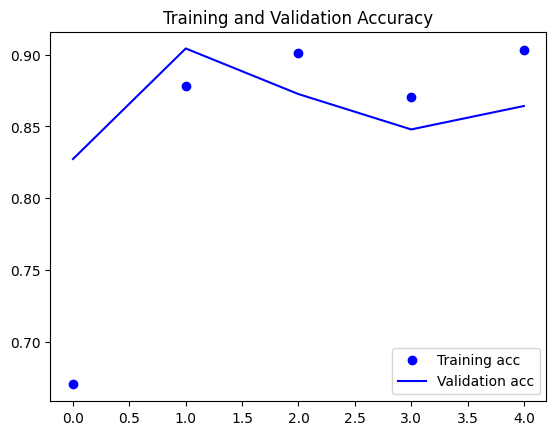

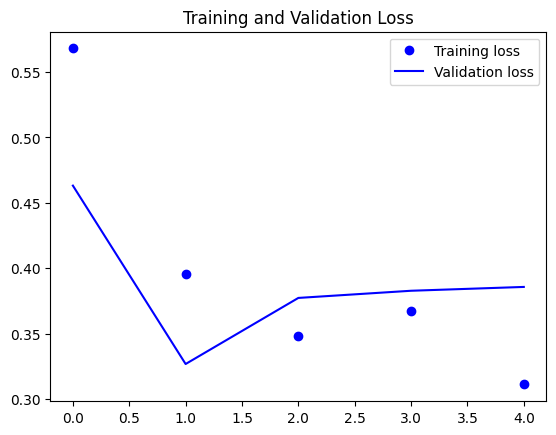

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

print(dataset[['genre', 'label']].head())
 
# Usamos la columna 'desc' como entrada y las etiquetas generadas como salida

texts = dataset['clean_description'].fillna("").tolist()

labels = dataset['label'].values
 
# Tokenización y Padding

max_features = 10000  # Número máximo de palabras a considerar

tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
 
maxlen = 500  # Longitud máxima de cada secuencia

data = pad_sequences(sequences, maxlen=maxlen)

print("Forma de las secuencias procesadas:", data.shape)
 
# Definición del modelo RNN para clasificación (ficción vs. no ficción) con mejoras para evitar overfitting

model = Sequential()

model.add(Embedding(max_features, 32, input_length=maxlen))

model.add(Dropout(0.1))  # Dropout tras la capa de Embedding para regularización

# Se reduce el número de neuronas a 16 e incorporamos dropout en la capa RNN

# model.add(SimpleRNN(16, dropout=0.1, recurrent_dropout=0.1))

model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.1)))

model.add(Dense(1, activation='sigmoid'))

model.summary()
 
# Compilamos el modelo con optimizador, función de pérdida y métrica de precisión

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
 
# Callback EarlyStopping para detener el entrenamiento si no mejora la validación

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
 
# Entrenamiento del modelo

history = model.fit(data, labels, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stop],class_weight=class_weights)
 
# Visualización de la precisión y pérdida durante el entrenamiento

acc = history.history['acc']

val_acc = history.history['val_acc']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(len(acc))
 
plt.figure()

plt.plot(epochs_range, acc, 'bo', label='Training acc')

plt.plot(epochs_range, val_acc, 'b', label='Validation acc')

plt.title('Training and Validation Accuracy')

plt.legend()
 
plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')

plt.plot(epochs_range, val_loss, 'b', label='Validation loss')

plt.title('Training and Validation Loss')

plt.legend()
 
plt.show()

 

---
## 5.6. Conclusión general

Ambos modelos descartados comparten una arquitectura robusta, pero no logran superar las limitaciones observadas durante las pruebas:

- **Overfitting en ambos modelos**, visible en las curvas de entrenamiento.
- **Rendimiento moderado**, sin mejoras notables respecto a modelos base.
- **Problemas con la generalización**:  
  Especialmente el segundo modelo, que carece de un conjunto de test externo.
- **Clase minoritaria mal representada**, a pesar del uso de `class_weight`.
- **Coste computacional elevado** comparado con los resultados obtenidos.

> Por estas razones, estos modelos se han descartado en favor de alternativas más eficientes y con mejor capacidad de generalización.
